# Encoder Only

https://github.com/neelnanda-io/TransformerLens/blob/main/demos/BERT.ipynb

In [1]:
import torch, transformer_lens
from measureLM import visualizing, decoding, patching, scoring

from transformers import AutoTokenizer
from transformer_lens import HookedEncoder

In [2]:
model = HookedEncoder.from_pretrained("bert-base-cased")
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
model.cfg.spacing = ""
model.tokenizer = tokenizer

If using BERT for interpretability research, keep in mind that BERT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model bert-base-cased into HookedTransformer


### 1) Get activations


prompt 0
layer 0: [(0.0004, 'Poland'), (0.0, 'Warsaw'), (0.0002, 'London'), (0.0003, 'Berlin')]
layer 1: [(0.0008, 'Poland'), (0.0001, 'Warsaw'), (0.0003, 'London'), (0.0008, 'Berlin')]
layer 2: [(0.0005, 'Poland'), (0.0001, 'Warsaw'), (0.0003, 'London'), (0.0014, 'Berlin')]
layer 3: [(0.0002, 'Poland'), (0.0001, 'Warsaw'), (0.0007, 'London'), (0.0009, 'Berlin')]
layer 4: [(0.0002, 'Poland'), (0.0001, 'Warsaw'), (0.0006, 'London'), (0.0006, 'Berlin')]
layer 5: [(0.0001, 'Poland'), (0.0001, 'Warsaw'), (0.0004, 'London'), (0.0005, 'Berlin')]
layer 6: [(0.0002, 'Poland'), (0.0002, 'Warsaw'), (0.0007, 'London'), (0.0006, 'Berlin')]
layer 7: [(0.0002, 'Poland'), (0.0003, 'Warsaw'), (0.0008, 'London'), (0.0008, 'Berlin')]
layer 8: [(0.0002, 'Poland'), (0.0003, 'Warsaw'), (0.0022, 'London'), (0.0016, 'Berlin')]
layer 9: [(0.0006, 'Poland'), (0.0011, 'Warsaw'), (0.0192, 'London'), (0.0303, 'Berlin')]


/Users/niklasstoehr/Code/measureLM/measureLM/scoring.py:39: UserWarning: torch.sort is supported by MPS on MacOS 13+, please upgrade. Falling back to CPU (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/Sort.mm:30.)
  token_ranks = torch.argsort(scores, descending=True)
/Users/niklasstoehr/Code/measureLM/measureLM/scoring.py:42: UserWarning: MPS: nonzero op is supported natively starting from macOS 13.0. Falling back on CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/Indexing.mm:218.)
  token_rank = torch.where(token_ranks == token_id)[0].item()


layer 10: [(0.0068, 'Poland'), (0.0066, 'Warsaw'), (0.0417, 'London'), (0.0909, 'Berlin')]
layer 11: [(0.0159, 'Poland'), (0.0104, 'Warsaw'), (0.0556, 'London'), (0.3333, 'Berlin')]


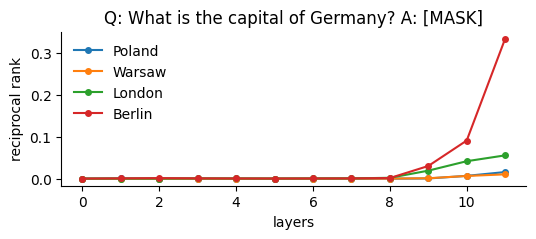

In [3]:
prompts = ['Q: What is the capital of Germany? A: [MASK]']
logits, activs, tokens = decoding.encode(prompts, model)
layer_scores = decoding.early_decoding(activs, model)

token_candidates = ["Poland", "Warsaw", "London", "Berlin"]
tok_idx = scoring.token_select(tokens, model, select_token="[MASK]")
scored_tokens = scoring.scores_to_tokens(layer_scores, tok_idx, model, mode=token_candidates)
visualizing.visualize_token_ranks(scored_tokens, token_candidates, prompts)

### (2) Use activations to intervene

['mug', 'table', 'cup']
extracting blocks.0.hook_resid_post
extracting blocks.1.hook_resid_post
extracting blocks.2.hook_resid_post
extracting blocks.3.hook_resid_post
extracting blocks.4.hook_resid_post
extracting blocks.5.hook_resid_post
extracting blocks.6.hook_resid_post
extracting blocks.7.hook_resid_post
patching blocks.8.hook_mlp_out
extracting blocks.8.hook_resid_post
patching blocks.9.hook_mlp_out
extracting blocks.9.hook_resid_post
patching blocks.10.hook_mlp_out
extracting blocks.10.hook_resid_post
patching blocks.11.hook_mlp_out
extracting blocks.11.hook_resid_post

prompt 0
layer 0: [(0.0002, 'Germany'), (0.0002, 'Berlin'), (0.0007, 'mug'), (0.0002, 'Paris'), (0.0002, 'table')]
layer 1: [(0.0005, 'Germany'), (0.0003, 'Berlin'), (0.0002, 'mug'), (0.0006, 'Paris'), (0.0001, 'table')]
layer 2: [(0.0004, 'Germany'), (0.0003, 'Berlin'), (0.0005, 'mug'), (0.0156, 'Paris'), (0.0001, 'table')]
layer 3: [(0.0002, 'Germany'), (0.0002, 'Berlin'), (0.0005, 'mug'), (0.0082, 'Paris'), (

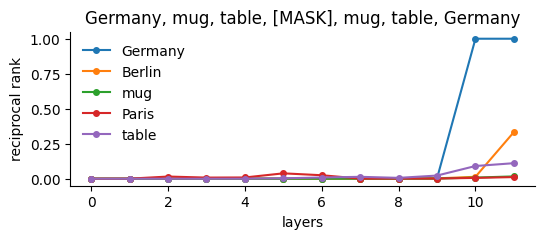

In [6]:
new_prompts = ["Germany, mug, table, [MASK], mug, table, Germany"]
new_logits, new_activs, new_tokens = decoding.encode(new_prompts, model)
insert_tok_idx = scoring.token_select(new_tokens, model, select_token="[MASK]")
pred = model.tokenizer.convert_ids_to_tokens(torch.topk(new_logits[insert_tok_idx], k=3).indices.tolist()[0])
print(pred)


patch_map = patching.create_hook_mapping(model, extract_l=(8, 12), patch_l=(8, 12))
patch_logits, resid_post = patching.intervene(new_tokens, activs, model, patch_map, extract_tok_idx=tok_idx, insert_tok_idx=insert_tok_idx)
resid_layer_scores = decoding.early_decoding(resid_post, model)

new_token_candidates = ["Germany", "Berlin", "mug", "Paris", "table"]

## scoring
extract_tok_idx = scoring.token_select(new_tokens, model, select_token="[MASK]")
scored_tokens = scoring.scores_to_tokens(resid_layer_scores, extract_tok_idx, model, mode=new_token_candidates)
visualizing.visualize_token_ranks(scored_tokens, new_token_candidates, new_prompts)
